# Installing the necessary libraries

In [1]:
# Install python pacakges
!pip install -q PubChemPy==1.0.4             # Install PubChemPy library for accessing PubChem data
!pip install -q rdkit-pypi==2022.09.5        # Install rdkit-pypi package, a version of the RDKit cheminformatics toolkit
!pip install -q scikit-optimize==0.10.1      # Install scikit-optimize library for optimization in machine learning

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.9 MB/s eta 0:00:00


In [2]:

import pandas as pd                            # Data manipulation and analysis library
import numpy as np                             # Numerical operations library
np.int = np.int32                              # To slove the error about AttributeError: module 'numpy' has no attribute 'int'  # Set default integer type to int32
np.float = np.float64                          # Set default float type to float64
import seaborn as sns                          # Statistical data visualization library
import pubchempy as pcp                        # PubChem API for accessing chemical information
from pubchempy import get_compounds, Compound  # Functions for working with PubChem data
from collections import Counter                # Container for counting hashable objects

# Molecular Descriptors Calculation
from rdkit import Chem                                 # Toolkit for cheminformatics
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs  # Molecular descriptors and fingerprint generation
from rdkit.DataStructs import ExplicitBitVect          # Data structures for working with molecular descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors   # Calculation of molecular descriptors

# Modeling
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold   # Model selection and evaluation tools
from sklearn import metrics                           # Metrics for evaluating model performance
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from pandas.core.common import random_state           # Setting random state for reproducibility
from sklearn.neighbors import KNeighborsRegressor     # K-Nearest Neighbors regression algorithm development
from sklearn.ensemble import RandomForestRegressor    # Random Forest regression algorithm development
from sklearn.svm import SVR                           # Support Vector Regression algorithm development
from sklearn.metrics import mean_squared_error, r2_score, make_scorer   # Metrics for evaluating regression model performance

# Visualization
import matplotlib.pyplot as plt   # Plotting library
# Setting matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline

# import the data set

In [3]:
from google.colab import files
upload = files.upload()

Saving ECFP6_descrs.csv to ECFP6_descrs.csv


In [4]:
from google.colab import files
upload = files.upload()

Saving FCFP6_descrs.csv to FCFP6_descrs.csv


In [5]:
from google.colab import files
upload = files.upload()

Saving MACCS_descrs.csv to MACCS_descrs.csv


In [6]:
from google.colab import files
upload = files.upload()

Saving medDog.csv to medDog.csv


In [7]:
from google.colab import files
upload = files.upload()

Saving rdkit_descrs.csv to rdkit_descrs.csv


In [8]:
from google.colab import files
upload = files.upload()

Saving X_rdkit_descrs_scal.csv to X_rdkit_descrs_scal.csv


In [9]:
df = pd.read_csv('medDog.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CAS        179 non-null    object 
 1   LambdaZHl  179 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


# Extracting SMILES codes from PubChem database

In [ ]:
'''
This script enables automatically connecting to the PubChem database,
Transfer of CAS numbers which are converted to CID identifiers
as first step and then resolved to respective SMILES codes.

'''

def cas_to_cid (df):

  df['PubChemCID'] = None
  # Searching PubChem for CID
  for i, CAS in df['CAS'].items():
    try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot error message: server is busy

  # Check PubChemCID; If CID is None, run the "While loop" and request PubChem server again to get all Cid
  while df['PubChemCID'].isnull().sum() > 0:
    print (df['PubChemCID'].isnull().sum())
    for i, CAS in df[df['PubChemCID'].isnull()]['CAS'].items():
      try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")
      except Exception as e:
        pass

  return df

# Function for searching and extracting SMILES code with entering CID
def cid_to_smiles (data):
  data['SMILES'] = None

  for i, cid in data['PubChemCID'].items():
    try:
      compound = pcp.Compound.from_cid(cid)
      if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
      else:
        print(f'No results found for PubChemCID {cid}')

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot error message: "PUG-REST server is busy"

  # Check SMILES; If SMILES is None, run the "While loop" and request PubChem server again to get all SMILES
  while data['SMILES'].isnull().sum() > 0:
    print (data['SMILES'].isnull().sum())
    for i, cid in data[data['SMILES'].isnull()]['PubChemCID'].items():
     try:
       compound = pcp.Compound.from_cid(cid)
       if compound:
        smiles = compound.canonical_smiles
        data.at[i, 'SMILES'] = smiles
       else:
        print(f'No results found for PubChemCID {cid}')
     except Exception as e:
       pass

  return data

In [ ]:
# Define a function that transform SMILES string into RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index = smiles, columns=desc_names)


# Define a funciton that transform a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr (smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use stadnard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a funciton that transform a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a funciton that transform a SMILES string into an MACCS fingerprints

def cal_MACCS_descr (smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

In [ ]:
df_with_cids = cas_to_cid(df)
df_with_smiles = cid_to_smiles(df_with_cids)

In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df['SMILES']).drop(['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'],axis=1)
rdkit_descrs.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,15.369928,-6.372005,15.369928,0.975631,0.034621,679.776,630.384,679.365324,268,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,13.470407,-4.324334,13.470407,0.943689,0.105982,494.452,472.276,494.121297,186,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,13.637567,-4.432959,13.637567,0.912260,0.357108,460.391,440.231,460.100561,174,0,...,0,0,0,0,0,0,0,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,13.964906,-4.447231,13.964906,0.690309,0.484773,456.322,433.138,455.090243,162,0,...,0,0,0,0,0,0,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,9.534722,-5.090278,9.534722,0.132186,0.189813,448.479,428.319,448.072256,160,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ECFP6_descrs = cal_ECFP6_descr(smiles=df['SMILES'])
ECFP6_descrs.head()

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
FCFP6_descrs = cal_FCFP6_descr(df_with_smiles['SMILES'])
FCFP6_descrs.head()

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,1,1,1,1,1,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
MACCS_descrs = cal_MACCS_descr(smiles=df['SMILES'])
MACCS_descrs.head()

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)C(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)O)NC(=O)C(CC(=O)O)NC(=O)C(CCCCN)NC(=O)C(CCCN=C(N)N)N,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
C1=CC(=C(C=C1CC(C(=O)O)OC(=O)C=CC2=C(C(=C(C=C2)O)O)C=CC3=CC(=C(C=C3)O)O)O)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
COC1=C(C=C2C(=C1O)C(=O)C=C(O2)C3=CC=CC=C3)OC4C(C(C(C(O4)C(=O)O)O)O)O,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
CCCC(=O)OCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)OC)C)C,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
CS(=O)(=O)[O-].CS(=O)(=O)[O-].C1=C[N+](=CC=C1C=NO)C[N+]2=CC=C(C=C2)C=NO,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1


In [11]:
# Checking for missing values
# if the results > 0, it means there is a missing value or several missing values
df.isna().sum().max()

0

In [ ]:
# Applying feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
X_rdkit_descrs_scal

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.736889,0.258054,0.736889,0.193164,0.027381,0.166078,0.165591,0.166081,0.176230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.645819,0.496482,0.645819,0.186839,0.105402,0.115762,0.119362,0.115755,0.120219,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.653833,0.483833,0.653833,0.180617,0.379963,0.106514,0.109992,0.106513,0.112022,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.669527,0.482172,0.669527,0.136673,0.519541,0.105410,0.107918,0.105151,0.103825,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.457129,0.407296,0.457129,0.026171,0.197056,0.103280,0.106509,0.103245,0.102459,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.775205,0.063732,0.775205,0.393626,0.312274,0.180809,0.174971,0.180794,0.196721,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.708081,0.222374,0.708081,0.331810,0.179247,0.232411,0.229953,0.232402,0.244536,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.665646,0.594545,0.665646,0.019066,0.534912,0.083982,0.086021,0.083974,0.090164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.704646,0.412160,0.704646,0.056926,0.351202,0.150704,0.151981,0.150566,0.153005,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y = df['LambdaZHl']

In [13]:
# No SMILES for correlation
ECFP6_descrs = pd.read_csv('ECFP6_descrs.csv')
FCFP6_descrs = pd.read_csv('FCFP6_descrs.csv')
MACCS_descrs = pd.read_csv('MACCS_descrs.csv')
X_rdkit_descrs_scal = pd.read_csv('X_rdkit_descrs_scal.csv')

In [14]:

X_rdkit = pd.concat([ X_rdkit_descrs_scal.reset_index(drop=True)], axis = 1)
X_ECFP6 = pd.concat([ECFP6_descrs.reset_index(drop=True)], axis = 1)
X_FCFP6 = pd.concat([FCFP6_descrs.reset_index(drop=True)], axis = 1)
X_MACCS = pd.concat([MACCS_descrs.reset_index(drop=True)], axis = 1)
All_descr = pd.concat([ X_rdkit_descrs_scal.reset_index(drop=True), X_ECFP6.reset_index(drop=True), X_FCFP6.reset_index(drop=True), X_MACCS.reset_index(drop=True)], axis = 1)

In [ ]:
X = pd.concat([
               X_rdkit_descrs_scal.reset_index(drop=True),
               ECFP6_descrs.reset_index(drop=True),
               FCFP6_descrs.reset_index(drop=True),
               MACCS_descrs.reset_index(drop=True)], axis=1)
display(X)

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
0,0.736889,0.258054,0.736889,0.193164,0.027381,0.166078,0.165591,0.166081,0.176230,0.0,...,1,1,1,1,1,1,1,1,1,0
1,0.645819,0.496482,0.645819,0.186839,0.105402,0.115762,0.119362,0.115755,0.120219,0.0,...,1,0,1,0,0,1,1,1,1,0
2,0.653833,0.483833,0.653833,0.180617,0.379963,0.106514,0.109992,0.106513,0.112022,0.0,...,1,0,1,1,0,1,1,1,1,0
3,0.669527,0.482172,0.669527,0.136673,0.519541,0.105410,0.107918,0.105151,0.103825,0.0,...,1,1,1,1,1,1,1,1,1,0
4,0.457129,0.407296,0.457129,0.026171,0.197056,0.103280,0.106509,0.103245,0.102459,0.0,...,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.775205,0.063732,0.775205,0.393626,0.312274,0.180809,0.174971,0.180794,0.196721,0.0,...,1,1,1,1,1,0,1,1,1,0
175,0.708081,0.222374,0.708081,0.331810,0.179247,0.232411,0.229953,0.232402,0.244536,0.0,...,1,1,1,1,1,0,1,1,1,0
176,0.665646,0.594545,0.665646,0.019066,0.534912,0.083982,0.086021,0.083974,0.090164,0.0,...,1,0,1,1,1,1,1,1,1,0
177,0.704646,0.412160,0.704646,0.056926,0.351202,0.150704,0.151981,0.150566,0.153005,0.0,...,1,1,1,1,1,1,1,1,1,1


# Build machine learning modeling piple

In [15]:
# Install python pacakges
!pip install --upgrade typing-extensions==3.10.0.2  # To address the error of dependency conflicts

!pip install -q scikit-optimize         # Install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]    # Install scikeras package with TensorFlow support
!pip install keras-tuner --upgrade

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.36 requires typing-extensions>=4.6.0, but you have typing-extensions 3.10.0.2 which is incompatible.
altair 5.5.0 requires typing-extensions>=4.10.0; python_version < "3.14", but you have typing-extensions 3.10.0.2 which is incompatible.
arviz 0.20.0 requires typing-extensions>=4.1.0, but you have typing-extensions 3.10.0.2 which is incompatible.
bigframes 1.29.0 requires typing-extensions<5,>=4.3.0, but you have typing-extensions 3.10.0.2 which is incompatible.
chex 0.1.88 requires typing_extensions>=4.2.0, but you have typing-extensions 3.10.0.2 which is incompatible.
cloudpathlib 0.20.0 requires typin

In [16]:

# Import basic packages for data manipulation, visualization, and machine learning
import numpy as np                                       # Numerical operations
import seaborn as sns                                    # Statistical data visualization
import pandas as pd                                      # Data manipulation and analysis
import tensorflow as tf                                  # Open-source machine learning framework
import os                                                # Operating system functionality
import scikeras                                          # Keras-based interface for scikit-learn
from tensorflow import keras                             # Keras API for building and training neural networks
import matplotlib.pyplot as plt                          # Plotting library
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Toolkit for creating plots with colorbars
import matplotlib.colors as colors                       # Color mapping and normalization
import matplotlib as mpl                                 # Matplotlib library for plotting
import keras_tuner                                       # Hyperparameter tuning library
from numpy.random import seed                            # Seed for reproducibility
import tensorflow                                        # Importing TensorFlow module

# Import Keras-related packages for building neural networks
from tensorflow import keras                             # Keras API for building and training neural networks
from keras.models import Sequential                      # Linear stack of layers for building models
from keras.layers import Dense                           # Fully connected layer
from keras.layers import Dropout                         # Dropout regularization for reducing overfitting
from keras import regularizers                           # Regularization techniques for neural networks
from tensorflow.keras.optimizers import Adam, SGD        # Optimization algorithms
from tensorflow.keras.optimizers.schedules import ExponentialDecay  # Learning rate schedule
from keras.models import load_model                      # Load pre-trained models
from keras.callbacks import EarlyStopping                # Early stopping during model training
from keras_tuner import BayesianOptimization             # Bayesian optimization for hyperparameter tuning
from tensorflow import keras                             # Keras API for building and training neural networks
from tensorflow.keras import layers                      # Keras layers for building models
from keras_tuner import Objective                        # Objective functions for hyperparameter tuning
from tensorflow.keras.optimizers import Adam             # Adam optimizer
from sklearn.metrics import mean_squared_error as mse    # Mean Squared Error metric
from sklearn.model_selection import KFold                # KFold from scikit-learn for cross-validation

In [17]:

X_rdkit = pd.concat([ X_rdkit_descrs_scal.reset_index(drop=True)], axis = 1)
X_ECFP6 = pd.concat([ECFP6_descrs.reset_index(drop=True)], axis = 1)
X_FCFP6 = pd.concat([FCFP6_descrs.reset_index(drop=True)], axis = 1)
X_MACCS = pd.concat([MACCS_descrs.reset_index(drop=True)], axis = 1)
All_descr = pd.concat([ X_rdkit_descrs_scal.reset_index(drop=True), X_ECFP6.reset_index(drop=True), X_FCFP6.reset_index(drop=True), X_MACCS.reset_index(drop=True)], axis = 1)

# Deep nerual network model with keras

In [18]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

# import keras related packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow.keras import layers
from keras_tuner import Objective


In [19]:
def build_model(hp):
  model = Sequential()

  # Input layer
  model.add(Dense(units = hp.Int('dense-bot', min_value=50,
             max_value=1024, step=12, default=50),
             activation = hp.Choice(
                 'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
             input_shape=(X_MACCS.shape[1],)))


  # Tune the number of units in the each dense layer
  for i in range (hp.Int('num_dense_layers',1,5)):
    model.add(Dense(units=hp.Int('dense_'+ str(i), min_value=50, max_value=512, step=25),
          activation = hp.Choice('act_l1',['relu','tanh','sigmoid'])))

    # Tune the droput rate in the each dense layer
    model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2, 0.3, 0.5])))


  # add output
  model.add(Dense(1,activation='linear'))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  elif hp_optimizer == 'SGD':
     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
     nesterov=True
     momentum=0.9

  model.compile(
    optimizer=hp_optimizer,
    loss='mse',
    metrics=['mse'])

  return model

In [20]:
# Check if the model code work correctly
import keras_tuner
build_model(keras_tuner.HyperParameters())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [40]:
# seed the random number generator to reproduce the same results
from numpy.random import seed
seed(2)

import tensorflow
tensorflow.random.set_seed(2)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
   X_MACCS, y, test_size=0.2, random_state=2)

In [42]:
tuner_bo = BayesianOptimization(
            hypermodel = build_model,
            objective = 'val_mse',
            max_trials =15,
            overwrite = True,
            executions_per_trial=3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
tuner_bo.search(X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size = 40,
        epochs = 900, verbose = 0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [44]:
# Get the top 2 models
best_params=tuner_bo.get_best_hyperparameters()
best_params[0].values

{'dense-bot': 86,
 'dense_activation': 'tanh',
 'num_dense_layers': 4,
 'dense_0': 150,
 'act_l1': 'sigmoid',
 'dropout_0': 0.5,
 'Optimizer': 'SGD',
 'learning_rate': 0.01,
 'dense_1': 425,
 'dropout_1': 0.3,
 'dense_2': 450,
 'dropout_2': 0.5,
 'dense_3': 300,
 'dropout_3': 0.0,
 'dense_4': 400,
 'dropout_4': 0.3}

In [45]:
best_model= tuner_bo.get_best_models()[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 86)                  │          14,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          13,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 425)                 │          64,175 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 425)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 450)                 │         191,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 300)                 │         135,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,974 (1.60 MB)

 Trainable params: 418,974 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# save model and architecture to single file
best_model.save("best_model.h5")
print("Saved model to disk")

Saved model to disk


In [47]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import load_model

# Load the model
best_model_v2 = load_model('best_model.h5', compile=False)

# Make predictions on the training and testing sets
train_preds_v2 = best_model_v2.predict(X_train)
test_preds_v2 = best_model_v2.predict(X_test)

# Calculate R2 scores
train_r2 = r2_score(y_train, train_preds_v2)
test_r2 = r2_score(y_test, test_preds_v2)

# Calculate MSE and then compute RMSE manually
train_mse = mean_squared_error(y_train, train_preds_v2)
test_mse = mean_squared_error(y_test, test_preds_v2)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("Train R2 Score : %.2f" % train_r2)
print("Test R2 Score : %.2f" % test_r2)
print("Train RMSE: %.2f" % train_rmse)
print("Test RMSE: %.2f" % test_rmse)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train R2 Score : 0.71
Test R2 Score : 0.44
Train RMSE: 4.95
Test RMSE: 4.50


# Display the R-squared value on scatterplot with regression model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


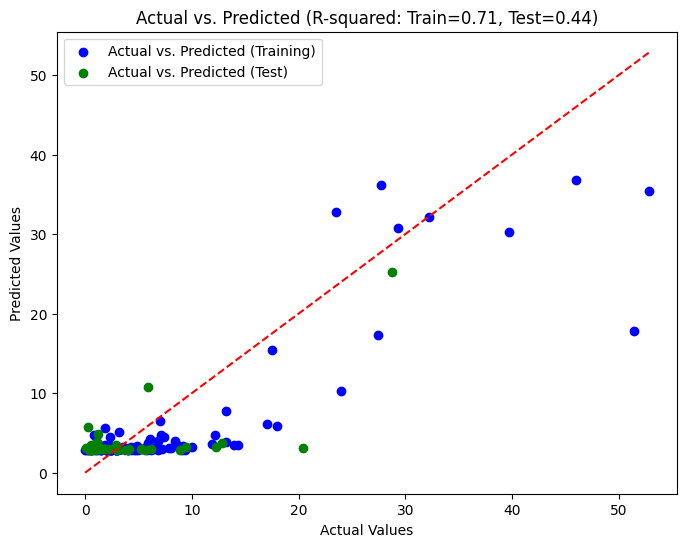

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming you already have the X_train, X_test, y_train, and y_test defined

# Make predictions using the model
test_preds_v2 = best_model_v2.predict(X_test)
train_preds_v2 = best_model_v2.predict(X_train)

# Calculate R-squared values
train_r2 = r2_score(y_train, train_preds_v2)
test_r2 = r2_score(y_test, test_preds_v2)

# Create a scatterplot to visualize the predictions versus the actual values
plt.figure(figsize=(8, 6))

# Plot training data in blue
plt.scatter(y_train, train_preds_v2, c='blue', label='Actual vs. Predicted (Training)')

# Plot test data in green
plt.scatter(y_test, test_preds_v2, c='green', label='Actual vs. Predicted (Test)')

# Plot the perfect prediction line
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], color='red', linestyle='--')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs. Predicted (R-squared: Train={train_r2:.2f}, Test={test_r2:.2f})')
plt.legend()

# Save the plot as a TIFF image with a specific name
plt.savefig("scatterplot_with_r2.tiff", format="tiff", dpi=320)  # Change the file name and dpi as needed

plt.show()


# K-fold cross validation

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse, r2_score
from keras.models import load_model
import numpy as np

def create_model():
    model = load_model('best_model.h5', compile=False)
    model.compile(loss='mse', optimizer='SGD')
    return model

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
cvr2scores = []
cvrmsescores = []

for train_ix, test_ix in kfold.split(X_train):
    # split data
    X_train_n, X_test_n = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_n, y_test_n = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # create model
    model = create_model()
    model.fit(X_train_n, y_train_n, epochs=900, batch_size=40, verbose=0)

    test_pred = model.predict(X_test_n)
    r2score = r2_score(y_test_n, test_pred)
    rmse = np.sqrt(mse(y_test_n, test_pred))

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

print("The 5-cv r2 Score was: %.2f (+/-) %.2f" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-cv rmse Score was: %.2f (+/-) %.2f" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
The 5-cv r2 Score was: 0.38 (+/-) 0.24
The 5-cv rmse Score was: 6.79 (+/-) 1.44


# Applicability domain

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Training Applicability Domain: 98.60%
Test Applicability Domain: 97.22%
Training set chemicals exceeding AD area: [ 23 113]
Test set chemicals exceeding AD area: [4]


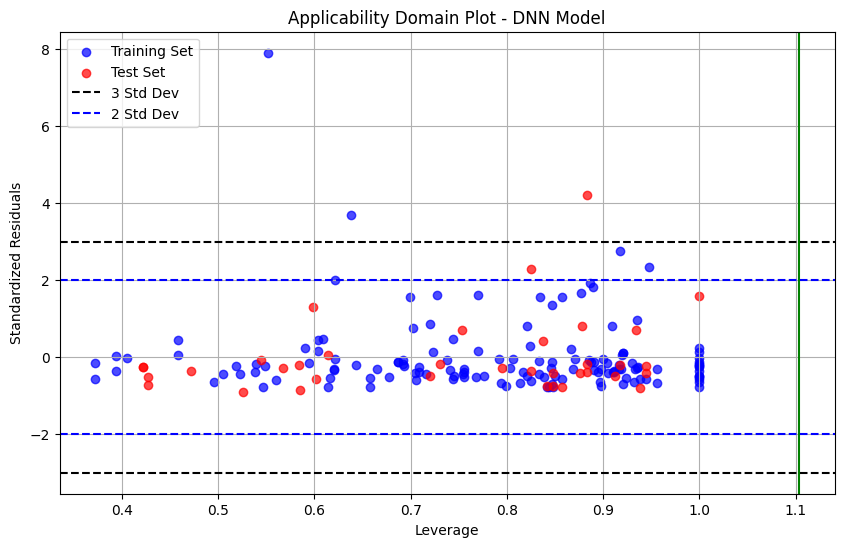

In [50]:
# Import necessary libraries
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the best DNN model from the BayesianOptimization search
best_model_rdkit = load_model("best_model.h5", custom_objects={'mse': mean_squared_error}) # Pass the correct loss function name

# ... (rest of your code remains the same)
def hat_matrix(X):
    xtx = np.dot(X.T, X)
    np.fill_diagonal(xtx, np.diagonal(xtx) + np.random.uniform(0.001, 0.002, size=len(xtx)))
    ixtx = np.linalg.pinv(xtx)
    return np.dot(np.dot(X, ixtx), X.T)

# Define the applicability domain function for DNN
def eval_ad_dnn(X_train, X_test, y_train, y_test, model):

    # Get predictions from the DNN model
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Reshape y_train and y_pred_train to 1-dimensional arrays
    y_train = y_train.to_numpy().reshape(-1)
    y_pred_train = y_pred_train.reshape(-1)
    y_pred_train = y_pred_train.reshape(-1)
    y_pred_test = y_pred_test.reshape(-1)

    residual_train = np.abs(y_train - y_pred_train)
    residual_test = np.abs(y_test - y_pred_test)
    s_residual_train = (residual_train - np.mean(residual_train)) / np.std(residual_train)
    s_residual_test = (residual_test - np.mean(residual_test)) / np.std(residual_test)

    H_train = hat_matrix(np.vstack((X_train, X_test)))

    leverage_train = np.diag(H_train)[:X_train.shape[0]]
    leverage_test = np.diag(H_train)[X_train.shape[0]:]

    p = X_train.shape[1] + 1  # features
    n = X_train.shape[0] + X_test.shape[0]  # total compounds
    h_star = (3 * p) / n

    AD_train = 100 * np.sum((leverage_train < h_star) & (np.abs(s_residual_train) < 3)) / len(leverage_train)
    AD_test = 100 * np.sum((leverage_test < h_star) & (np.abs(s_residual_test) < 3)) / len(leverage_test)

    return AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_MACCS, y, test_size=0.2, random_state=35)

# Evaluate applicability domain for the best DNN model
AD_train, AD_test, s_residual_train, s_residual_test, leverage_train, leverage_test = eval_ad_dnn(X_train, X_test, y_train, y_test, best_model_rdkit)

# Find chemicals exceeding AD area
train_exceed_AD = (leverage_train > np.mean(leverage_train) + 2 * np.std(leverage_train)) | \
                  (np.abs(s_residual_train) > 3)
test_exceed_AD = (leverage_test > np.mean(leverage_test) + 2 * np.std(leverage_test)) | \
                 (np.abs(s_residual_test) > 3)
# Create Williams plot for DNN model
plt.figure(figsize=(10, 6))

# Scatter plot for training set
plt.scatter(leverage_train, s_residual_train, c='blue', label='Training Set', alpha=0.7)

# Scatter plot for test set
plt.scatter(leverage_test, s_residual_test, c='red', label='Test Set', alpha=0.7)

# Horizontal lines for the R-squared bounds
plt.axhline(y=np.mean(s_residual_train) + 3 * np.std(s_residual_train), color='black', linestyle='--', label='3 Std Dev')
plt.axhline(y=np.mean(s_residual_train) - 3 * np.std(s_residual_train), color='black', linestyle='--')

# Vertical line for leverage bound
plt.axhline(y=np.mean(s_residual_train) + 2 * np.std(s_residual_train), color='blue', linestyle='--', label='2 Std Dev')
plt.axhline(y=np.mean(s_residual_train) - 2 * np.std(s_residual_train), color='blue', linestyle='--')

plt.axvline(x=np.mean(leverage_train) + 2 * np.std(leverage_train), color='green', linestyle='-')

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Applicability Domain Plot - DNN Model')
plt.legend()
plt.grid(True)

# Save the plot as a TIFF image with a specific name
plt.savefig("AD_Plot.tiff", format="tiff", dpi=300)  # Change the file name and dpi as needed

# Print results
print("Training Applicability Domain: {:.2f}%".format(AD_train))
print("Test Applicability Domain: {:.2f}%".format(AD_test))
print("Training set chemicals exceeding AD area:", np.where(train_exceed_AD)[0])
print("Test set chemicals exceeding AD area:", np.where(test_exceed_AD)[0])

# Show the plot
plt.show()
